参考：<a href="https://qiita.com/inoory/items/e63ade6f21766c7c2393">[Python] Keras-RLで簡単に強化学習(DQN)を試す</a>

### CSVファイルからデータを読み込む

In [13]:
#ライブラリーを読み込む
import pandas as pd
pd.set_option('precision', 2)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import datetime

# データの読込と表示
df_orig = pd.read_csv(
    "17_preprocessed.csv",
    sep="," ,
    skiprows = 1,
    header= 1,
    encoding = "Shift_JISx0213").set_index("年月日時")
df_orig.head()            # 統計量の表示

df_orig = df_orig[24 * 30:-24*30] # 冬は雨ではなく雪のため除く

print("data loaded", len(df_orig))

data loaded 7319


### データを標準化する

In [2]:
df =  (df_orig - df_orig.mean()) / (df_orig.std())
df.head()

,気温(℃),降水量(mm),降雪(cm),積雪(cm),日照時間(時間),風速(m/s),風向,露点温度(℃),蒸気圧(hPa),相対湿度(％),海面気圧(hPa),現地気圧(hPa),日射量(MJ/㎡),天気,視程(km),雲量(10分比)
年月日時,,,,,,,,,,,,,,,,
2017/1/31 1:00,-1.70,-0.14,-0.07,4.99,-0.61,-0.39,-1.03,-1.34,-1.14,0.99,0.57,0.18,-0.68,2.48,-2.02,0.72
2017/1/31 2:00,-1.70,-0.14,8.51,5.39,-0.61,0.34,-1.46,-1.47,-1.19,0.52,0.69,0.33,-0.68,2.48,-2.02,0.72
2017/1/31 3:00,-1.66,-0.14,-0.07,4.99,-0.61,1.19,1.71,-1.81,-1.33,-0.59,0.86,0.51,-0.68,2.48,-0.47,0.72
2017/1/31 4:00,-1.89,-0.14,-0.07,4.99,-0.61,0.12,-0.82,-1.62,-1.26,0.64,1.06,0.67,-0.68,2.48,-0.47,0.72
2017/1/31 5:00,-1.89,-0.14,-0.07,4.99,-0.61,2.27,-0.61,-1.62,-1.26,0.64,1.19,0.83,-0.68,2.48,-0.47,0.72


In [5]:
pd.reset_option("display.precision")
pd.DataFrame(df.corr()["降水量(mm)"])

,降水量(mm)
気温(℃),0.046919
降水量(mm),1.000000
降雪(cm),0.042667
積雪(cm),-0.016431
日照時間(時間),-0.082510
風速(m/s),-0.004945
風向,-0.015147
露点温度(℃),0.113077
蒸気圧(hPa),0.124163
相対湿度(％),0.167913


In [6]:
TEST_DATA_LENGTH = 24 * 30  # 1か月分をテストデータとする
df_test = df[:-TEST_DATA_LENGTH]

In [10]:
import gym
import gym.spaces
import numpy as np

# 直線上を動く点の速度を操作し、目標(原点)に移動させることを目標とする環境
class PointOnLine(gym.core.Env):
    def __init__(self):
        self.action_space = gym.spaces.Discrete(2) # 行動空間。傘をさす、ささない2種

        # 観測空間(state)の次元 (位置と速度の2次元) とそれらの最大値・最小値
        self.observation_space = gym.spaces.Box(low=np.array([min(x) for x in df.values.T]), high=np.array([max(x) for x in df.values.T]))
        
        self.index = 0

    # 各stepごとに呼ばれる
    # actionを受け取り、次のstateとreward、episodeが終了したかどうかを返すように実装
    def _step(self, action):
        
        '''
        # actionを受け取り、次のstateを決定
        dt = 0.1
        acc = (action - 1) * 0.1
        self._vel += acc * dt
        self._vel = max(-1.0,  min(self._vel, 1.0))
        self._pos += self._vel * dt
        self._pos = max(-1.0,  min(self._pos, 1.0))

        # 位置と速度の絶対値が十分小さくなったらepisode終了
        done = abs(self._pos) < 0.1 and abs(self._vel) < 0.1
        '''
        done = self.index >= (len(df_test) - 30)
        
        # 雨が降ったかどうか
        is_rain = df_test["降水量(mm)"].values[self.index] > 0.1
        is_umbrella = (action == 1)
        
        if is_rain:  # 雨が降っていいる
            if is_umbrella:   # 傘をさした
                reward = 10
            else:   # 傘をささなかった
                reward = -10
        else:  # 晴れている
            if is_umbrella:  # 傘をさした
                reward = -1
            else:  # 傘をささなかった
                reward = 0
                
        self.index = self.index + 1

        # 次のstate、reward、終了したかどうか、追加情報の順に返す
        # 追加情報は特にないので空dict
        return df_test.values[self.index+1], reward, done, {}

    # 各episodeの開始時に呼ばれ、初期stateを返すように実装
    def _reset(self):
        
        self.index = 0
        
        return np.array(df_test.values[0])

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy
from rl.memory import SequentialMemory

env = PointOnLine()
nb_actions = env.action_space.n

# DQNのネットワーク定義
model = Sequential()
model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(nb_actions))
model.add(Activation('linear'))
print(model.summary())

# experience replay用のmemory
memory = SequentialMemory(limit=5000, window_length=1)
# 行動方策はオーソドックスなepsilon-greedy。ほかに、各行動のQ値によって確率を決定するBoltzmannQPolicyが利用可能
policy = EpsGreedyQPolicy(eps=0.1) 
dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=100,
               target_model_update=1e-2, policy=policy)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])

history = dqn.fit(env, nb_steps=5000, visualize=False, verbose=2, nb_max_episode_steps=300)
#学習の様子を描画したいときは、Envに_render()を実装して、visualize=True にします,

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_5 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_6 (Activation)    (None, 16)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
activation_7 (Activation)    (None, 16)                0         
__________

Testing for 1 episodes ...
Episode 1: reward: 1695.000, steps: 6570


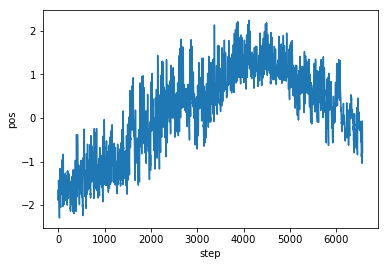

In [24]:
import rl.callbacks
class EpisodeLogger(rl.callbacks.Callback):
    def __init__(self):
        self.observations = {}
        self.rewards = {}
        self.actions = {}

    def on_episode_begin(self, episode, logs):
        self.observations[episode] = []
        self.rewards[episode] = []
        self.actions[episode] = []

    def on_step_end(self, step, logs):
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.actions[episode].append(logs['action'])

cb_ep = EpisodeLogger()
dqn.test(env, nb_episodes=1, visualize=False, callbacks=[cb_ep])


%matplotlib inline
import matplotlib.pyplot as plt

for obs in cb_ep.observations.values():
    plt.plot([o[0] for o in obs])
plt.xlabel("step")
plt.ylabel("pos")

In [19]:
for k in cb_ep.observations.keys():
    print(k)

0


In [21]:
cb_ep.observations[0]

6570

In [22]:
cb_ep.observations[0][0]

array([-1.66101637, -0.13585566, -0.06559412,  4.98813894, -0.61185322,
        1.19454863,  1.70806972, -1.80691019, -1.32861987, -0.58916526,
        0.85636892,  0.51493021, -0.68093485,  2.48057732, -0.46757026,
        0.71841909])